In [1]:
import aesmc.train as train
import aesmc.losses as losses
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from arm_models import DTC_2D_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # video plotting + params to coords
from aesmc import statistics # to simulate from prior and summarize post.
from aesmc import state

In [2]:
# define global params which we're not inferring 
# ToDo: onsider having consts dict
g= 0.2
dt=0.03
transition_scale = 0.1#0.05
emission_scale = 0.1#0.01
proposal_scale_0 = 0.1
proposal_scale_t = 0.05
initial_loc = torch.zeros(2)
initial_scale = 0.1 # * torch.eye(2)
# define true params (to simualte data from)
true_transition_mult = 1
true_emission_mult = 1
# if learning distributions:
init_transition_mult = 0
init_emission_mult = 0
# define train/infer params
num_timesteps = 100
num_test_obs = 10
test_inference_num_particles = 1000
saving_interval = 10
logging_interval = 10
batch_size = 10
num_iterations = 500
num_particles = 100

In [3]:
# set up true values. later, we'll initialize from a different point and see how well
# we're doing.
inits_dict_true = {}
inits_dict_true["L1"] = 1.25
inits_dict_true["L2"] = 0.75
inits_dict_true["M1"] = 0.5
inits_dict_true["M2"] = 0.35 
# init values for intermediate variables in the emission model
inits_dict_true["velocity_vec"] = torch.zeros([batch_size*num_particles, 2])
inits_dict_true["angle_vec"] = torch.zeros([batch_size*num_particles, 2])

### Define true distributions
To simulate data from the true model.

In [4]:
initial = DTC_2D_model.Initial(initial_loc, initial_scale)
transition = DTC_2D_model.Transition(true_transition_mult, transition_scale)
emission = DTC_2D_model.Emission(inits_dict_true, dt, g, emission_scale, False)

Define bootsrap or other proposal. It will serve us later for inference.

In [48]:
# proposal = DTC_2D_model.Proposal(proposal_scale_0, proposal_scale_t)

proposal = DTC_2D_model.Bootstrap_Proposal(initial_scale, initial_loc, 
                                             transition_scale, true_transition_mult)

In [49]:
# # ToDo: decide whether or not it's relevant here
# # set up data loader for simulated data from true distribution
# dataloader = train.get_synthetic_dataloader(
#             initial,
#             transition,
#             emission,
#             num_timesteps, batch_size)

my understanding - `statistics.sample_from_prior` instructs the objects to sample one particle no matter what is my num particles. now, when i'm giving an initial value that has `torch.Size[batch_size, num_particles, 2]` for the angles, with `num_particles` different from zero, this messes things up. Every intermediate quantity in the emmision should be aligned with the desired number of particles.

In [7]:
# use statistics.sample_from_prior to obtain simulated latens and observations
# now we're setting it to be a "one particle sample". it seems to work.
# but we'll have to reset number of particles to 100. ToDo: fix, generalize
# num_particles = 1
# inits_dict_true["velocity_vec"] = torch.zeros([batch_size*num_particles, 2])
# inits_dict_true["angle_vec"] = torch.zeros([batch_size*num_particles, 2])
# set random seed
np.random.seed(0)
torch.manual_seed(0)

sim_lats , sim_observs = statistics.sample_from_prior(initial,
                                transition,
                                emission, 
                                num_timesteps,
                                batch_size)
print(sim_lats[-1].size()) # [batch_size, dim_latents]
print(sim_observs[-1].size()) # [batch_size, dim_obs]

torch.Size([10, 2])
torch.Size([10, 6])


In [8]:
expanded = state.expand_observation(sim_observs[-1], num_particles)
expanded.shape

torch.Size([10, 100, 6])

In [8]:
# len(emission.angles)
# emission.angles[-1].shape
# len(emission.angles)
len(emission.acceleration) # one timestep less than others.

0

In [49]:
# save ground truth variables
true_angles_list = emission.angles
true_velocity_list = emission.velocity
true_acceleration_list = emission.acceleration
sim_accel = torch.cat([acc.unsqueeze(-1) for
                           acc in true_acceleration_list], dim=2)
sim_accel.shape

RuntimeError: expected a non-empty list of Tensors

In [9]:
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)

torch.Size([10, 2, 100])
torch.Size([10, 6, 100])


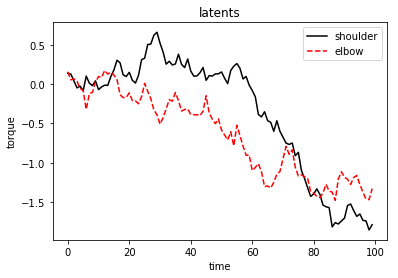

In [10]:
ind_in_batch = 6 # could be between 0 and batch_size-1
plt.plot(lat_data[ind_in_batch,0,:].detach().numpy(), 'black', label="shoulder");
plt.plot(lat_data[ind_in_batch,1,:].detach().numpy(), 'red', 
         linestyle = 'dashed', label = "elbow");
#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
plt.title('latents')
plt.ylabel('torque')
plt.xlabel('time')
plt.legend();
#plt.savefig('first_fig_aesmc.png')

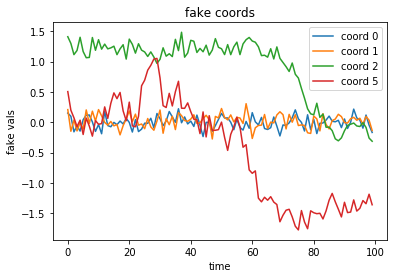

In [11]:
plt.plot(sim_data[ind_in_batch,0,:].detach().numpy(), label="coord 0");
plt.plot(sim_data[ind_in_batch,1,:].detach().numpy(), 
          label = "coord 1");
plt.plot(sim_data[ind_in_batch,2,:].detach().numpy(), 
         label = "coord 2");
plt.plot(sim_data[ind_in_batch,5,:].detach().numpy(), 
         label = "coord 5");
#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
plt.title('fake coords')
plt.ylabel('fake vals')
plt.xlabel('time')
plt.legend();

In [12]:
num_iterations = 600 # override previous statements. ToDo: define those here
# L1_init =  0.7
# L2_init = 1.3
training_stats = DTC_2D_model.TrainingStats(
                inits_dict_true["L1"], inits_dict_true["L2"],  # older func. update when working
                num_timesteps,
                logging_interval)

In [13]:
# define dataloader which we'll later use
dataloader = train.get_synthetic_dataloader(
            initial,
            transition,
            emission,
            num_timesteps, batch_size)

In [47]:
# train model to learn proposal

train.train(dataloader=dataloader, # loads ground truth observations
            num_particles=num_particles,
            algorithm='aesmc',
            initial=initial, # the true distribution, assume we're not learning
            transition=transition, # same here
            emission= emission, # same here
            proposal=proposal,# trainable instance
            num_epochs=5,
            num_iterations_per_epoch=num_iterations,
            callback=training_stats)

Iteration 0: Loss = 5867.6923828125
Iteration 10: Loss = 7722.50927734375
Iteration 20: Loss = 5883.15234375
Iteration 30: Loss = 2633.76513671875
Iteration 40: Loss = 5497.9853515625
Iteration 50: Loss = 1460.0240478515625
Iteration 60: Loss = 2289.110107421875
Iteration 70: Loss = 2622.110595703125
Iteration 80: Loss = 3478.158203125
Iteration 90: Loss = 717.2371215820312
Iteration 100: Loss = 7372.7236328125
Iteration 110: Loss = 547.9981689453125
Iteration 120: Loss = 5820.716796875
Iteration 130: Loss = 2212.25634765625
Iteration 140: Loss = 3511.276611328125
Iteration 150: Loss = 3789.08251953125
Iteration 160: Loss = 6674.3720703125
Iteration 170: Loss = 11269.134765625
Iteration 180: Loss = 2102.82373046875
Iteration 190: Loss = 7422.17333984375
Iteration 200: Loss = 1476.8824462890625
Iteration 210: Loss = 4990.208984375
Iteration 220: Loss = 7920.94677734375
Iteration 230: Loss = 3813.83203125
Iteration 240: Loss = 6864.1943359375
Iteration 250: Loss = 5554.736328125
Iteratio

KeyboardInterrupt: 

In [37]:
print(proposal.lin_t[0].weight)
print(proposal.lin_0[0].weight)

Parameter containing:
tensor([[ 0.4004,  0.3705,  0.0114, -0.0095, -0.0531, -0.0786, -0.0559, -0.0174,
          0.0084, -0.0065, -0.1805,  0.2658,  0.1119,  0.1466],
        [ 0.2475,  0.2330, -0.0026,  0.0017,  0.0994,  0.0119, -0.1410,  0.2712,
         -0.0158,  0.0048,  0.1963, -0.1006, -0.4382, -0.0707]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.1538, -0.1683, -0.0064, -0.0252,  0.1292,  0.2762],
        [-0.1798,  0.1120,  0.1054,  0.2376,  0.0131, -0.2093]],
       requires_grad=True)


In [50]:
from aesmc import inference

inference_result = inference.infer(
            inference_algorithm='smc',
            observations=sim_observs, 
            initial=initial,
            transition=transition,
            emission=emission,
            proposal=proposal,
            num_particles=1000
        )

In [51]:
# ToDo: consider wrapping in a function e.g., summarize_posterior(latents, their weights)
smc_smoothed_state_means = []
smc_smoothed_state_variances = []
for latent in inference_result['latents']:
    smc_smoothed_state_means.append(statistics.empirical_mean(
        latent, inference_result['log_weight']
    ))
    smc_smoothed_state_variances.append(statistics.empirical_variance(
        latent, inference_result['log_weight']
    ))

In [52]:
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2) # now b, should be obs in observations
smooth_mean =  torch.cat([mean.unsqueeze(-1) for
                           mean in smc_smoothed_state_means], dim=2)
smooth_var = torch.cat([var.unsqueeze(-1) for
                           var in smc_smoothed_state_variances], dim=2)

In [19]:
smooth_mean.shape

torch.Size([10, 2, 100])

In [28]:
ind_in_batch = 4
dim_lat_plot = 0
np.max(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy()) # 0! it's also not on the same scale

0.0071208477

In [18]:
# ToDo: consider wrapping in a function e.g., summarize_posterior(latents, their weights)
smc_smoothed_accel_means = []
smc_smoothed_accel_variances = []
for accel in emission.acceleration:
    smc_smoothed_accel_means.append(statistics.empirical_mean(
        accel.view(batch_size, 1000, 2), inference_result['log_weight']
    ))
    smc_smoothed_accel_variances.append(statistics.empirical_variance(
        accel.view(batch_size, 1000, 2), inference_result['log_weight']
    ))

In [19]:
recovered_accel = torch.cat([acc.unsqueeze(-1) for
                           acc in smc_smoothed_accel_means], dim=2) # now b, should be obs in observations

In [20]:
recovered_accel.shape

torch.Size([10, 2, 100])

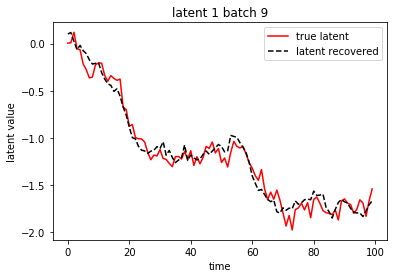

In [57]:
ind_in_batch = 9 # could be between 0 and batch_size-1
dim_lat_plot = 1
plt.plot(lat_data[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'red', label="true latent");
plt.plot(smooth_mean[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'black', 
         linestyle = 'dashed', label = "latent recovered");
# plt.plot(recovered_accel[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'black', 
#          linestyle = 'dashed', label = "accel recovered");
# plt.plot(sim_accel[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'blue', 
#           label = "true accel");
#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
plt.title('latent ' + str(dim_lat_plot) + 
        ' batch ' + str(ind_in_batch))
plt.ylabel('latent value')
plt.xlabel('time')
#plt.ylim([-10,10])
plt.legend();
#plt.savefig('first_fig_aesmc.png')

In [23]:
print(len(emission.angles))
print(len(inference_result["latents"]))

100
100


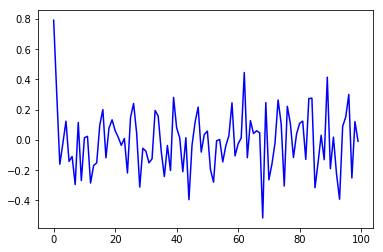

In [22]:
plt.plot(recovered_accel[ind_in_batch,dim_lat_plot,:].detach().numpy() - 
         sim_accel[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'blue', 
          label = "true accel");

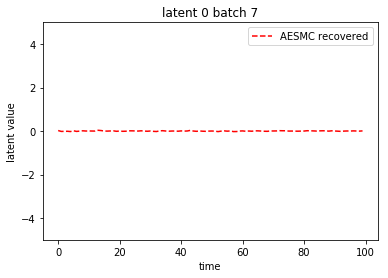

In [23]:
ind_in_batch = 7 # could be between 0 and batch_size-1
dim_lat_plot = 0
#plt.plot(lat_data[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'black', label="true");
plt.plot(smooth_mean[ind_in_batch,dim_lat_plot,:].detach().numpy()-
         lat_data[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'red', 
         linestyle = 'dashed', label = "AESMC recovered");
#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
plt.title('latent ' + str(dim_lat_plot) + 
        ' batch ' + str(ind_in_batch))
plt.ylabel('latent value')
plt.xlabel('time')
plt.ylim([-5,5])
plt.legend();
#plt.savefig('first_fig_aesmc.png')

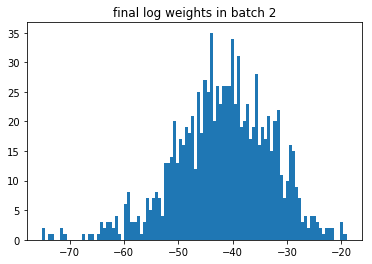

In [59]:
plt.hist(inference_result["log_weight"][ind_in_batch,:].detach().numpy(), bins=100);
plt.title("final log weights in batch "  + str(ind_in_batch));

In [43]:
torch.zeros(10*1,2,1)

tensor([[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]]])

In [46]:
emission.D(torch.zeros(10*1000)).shape

torch.Size([10000, 2, 2])

In [ ]:
plt.plot(sim_data[ind_in_batch,0,:].detach().numpy(), label="coord 0");
plt.plot(sim_data[ind_in_batch,1,:].detach().numpy(), 
          label = "coord 1");
plt.plot(sim_data[ind_in_batch,2,:].detach().numpy(), 
         label = "coord 2");
plt.plot(sim_data[ind_in_batch,5,:].detach().numpy(), 
         label = "coord 5");
#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
plt.title('fake coords')
plt.ylabel('fake vals')
plt.xlabel('time')
plt.legend();

In [37]:
print(emission.batch_size)
print(emission.num_particles)
print(emission.dim_latents)

10
1000
2


In [34]:
last_accel_raw = emission.acceleration[-1]
last_accel_raw.shape

torch.Size([10000, 2])

In [35]:
logi = last_accel_raw.contiguous().view(batch_size * 1000, 2, 1)[:,:,0] == last_accel_raw
logi.detach().numpy().all()

True

In [36]:
last_accel_raw_reshaped = last_accel_raw.contiguous().view(batch_size, 1000, 2)

In [41]:
batch_size_test = 10
num_particles_test = 100
dim_latents_test = 2

test_tens = torch.zeros(batch_size_test*num_particles_test, dim_latents_test, 1)
test_tens[321, 0, 0] = 1

In [42]:
# what i'm doing here worked for the acceleration.
# view (batch_size* num_particles, dim_latents,1)
# then squeeze(), view (batch_size* num_particles, dim_latents)
tt1 = test_tens.squeeze()
# then view (batch_size, num_particles, dim_latents)
tt2 = tt1.view(batch_size_test, num_particles_test, dim_latents_test)

In [45]:
print(np.where(test_tens==1))
print(np.where(tt1==1))
print(np.where(tt2==1))

(array([321]), array([0]), array([0]))
(array([321]), array([0]))
(array([3]), array([21]), array([0]))


In [38]:
logi = last_accel_raw.contiguous().view(batch_size * 1000, 2, 1).squeeze() == last_accel_raw
logi.detach().numpy().all()

True

In [23]:
# ToDo: consider wrapping in a function e.g., summarize_posterior(latents, their weights)
smc_smoothed_angle_means = []
smc_smoothed_angle_variances = []
for angle in emission.angles:
    smc_smoothed_angle_means.append(statistics.empirical_mean(
        angle.view(batch_size, 1000, 2), inference_result['log_weight']
    ))
    smc_smoothed_angle_variances.append(statistics.empirical_variance(
        angle.view(batch_size, 1000, 2), inference_result['log_weight']
    ))

In [24]:
smooth_mean_angle =  torch.cat([mean.unsqueeze(-1) for
                           mean in smc_smoothed_angle_means], dim=2)
smooth_var_angle = torch.cat([var.unsqueeze(-1) for
                           var in smc_smoothed_angle_variances], dim=2)

RuntimeError: expected a non-empty list of Tensors

In [54]:
ind_in_batch = 8 # could be between 0 and batch_size-1
x_hat , y_hat = arm_utils.coords_from_params_mat(smooth_mean_angle[ind_in_batch,0,:].detach().numpy(), 
                                       smooth_mean_angle[ind_in_batch,1,:].detach().numpy(), 
                                                 inits_dict_true["L1"], inits_dict_true["L2"])

In [55]:
x_obs = sim_data[ind_in_batch, [0,2,4], :].detach().numpy().T
y_obs = sim_data[ind_in_batch, [1,3,5], :].detach().numpy().T

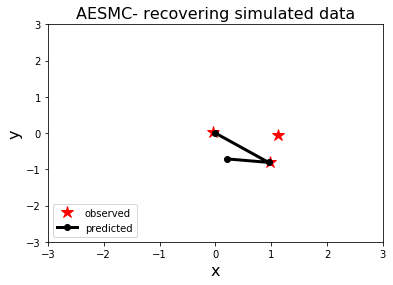

In [56]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             'DTC-2D_plots/dtc-2d-recovered', 
                   "AESMC- recovering simulated data", 
                             x_hat.shape[0], inits_dict_true["L1"] + 
                             inits_dict_true["L2"] + 1)

In [84]:
emission(latents=a, time=0)

RuntimeError: shape '[10, 100, 2]' is invalid for input of size 20

In [86]:
emission.angles[-1].shape

torch.Size([10, 2])